# Deep Recurrent Networks

To increase network complexity, we can make the RNNs "vertically deep" at each time step (i.e. deep in the usual FFN sense). Recall that RNNs are "horizontally deep" in the sense that early inputs at influence outputs and state at later time steps. But having depth in the usual sense allows learning *higher-order* state vectors $\boldsymbol{\mathsf{H}}^{\ell}_t.$

<br>

```{figure} ../../../img/nn/05-deep-rnn.svg
---
width: 330px
name: 05-deep-rnn
align: center
---
Deep RNN architecture. Observe that it requires $L$ state vectors at each step.
```

<br>

## Code implementation

In [1]:
from chapter import *

In [2]:
from torch.utils.data import random_split

tm = TimeMachine()
corpus, vocab = tm.build()
T = 30
BATCH_SIZE = 128

dataset = SequenceDataset(corpus, seq_len=T, vocab_size=len(vocab))
train_ds, valid_ds = random_split(dataset, [0.80, 0.20])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)    # also sampled

len(train_loader) * 128 * T, len(valid_loader) * 128 * T

(4181760, 1048320)

Let's train a **deep GRU net**. Since the current nodes (i.e. at any time step for fixed $\ell$) don't depend on later layers, we can compute the outputs at each time step in one layer, then pass the output sequence as input sequence to the next layer.

In [3]:
%%save
from functools import partial


class DeepRNN(nn.Module):
    def __init__(self, 
        cell: Type[nn.Module], 
        inputs_dim: int, 
        hidden_dim: int, 
        num_layers: int,
        **kwargs,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        for l in range(num_layers):
            if l == 0:
                self.layers.append(cell(inputs_dim, hidden_dim, **kwargs))
            else:
                self.layers.append(cell(hidden_dim, hidden_dim, **kwargs))

    def forward(self, x, state=None):
        if state is None:
            state = [None] * self.num_layers
        
        out = x
        for l in range(self.num_layers):
            out, state[l] = self.layers[l](out, state[l])

        return out, state


Deep = lambda cell: partial(DeepRNN, cell)

from functools import partial


class DeepRNN(nn.Module):
    def __init__(self, 
        cell: Type[nn.Module], 
        inputs_dim: int, 
        hidden_dim: int, 
        num_layers: int,
        **kwargs,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        for l in range(num_layers):
            if l == 0:
                self.layers.append(cell(inputs_dim, hidden_dim, **kwargs))
            else:
                self.layers.append(cell(hidden_dim, hidden_dim, **kwargs))

    def forward(self, x, state=None):
        if state is None:
            state = [None] * self.num_layers
        
        out = x
        for l in range(self.num_layers):
            out, state[l] = self.layers[l](out, state[l])

        return out, state


Deep = lambda cell: partial(DeepRNN, cell)

**Remark.** You can swap GRU out with any recurrent cell (e.g. RNN, LSTM).

In [4]:
gru = Deep(GRU)(5, 2, num_layers=3)
print(gru)

DeepRNN(
  (layers): ModuleList(
    (0): GRU(
      (R): Linear(in_features=7, out_features=2, bias=True)
      (Z): Linear(in_features=7, out_features=2, bias=True)
      (G): Linear(in_features=7, out_features=2, bias=True)
    )
    (1-2): 2 x GRU(
      (R): Linear(in_features=4, out_features=2, bias=True)
      (Z): Linear(in_features=4, out_features=2, bias=True)
      (G): Linear(in_features=4, out_features=2, bias=True)
    )
  )
)


Shape test:

In [5]:
x = torch.randn(32, 10, 5)
outs, state = gru(x)
assert outs.shape == (32, 10, 2)
assert state[0].shape == (32, 2)

Correctness for layers more than 1:

In [6]:
gru = Deep(GRU)(5, 2, num_layers=3)
gru_torch = nn.GRU(5, 2, num_layers=3, batch_first=True)

for net in [gru, gru_torch]:
    for name, p in net.named_parameters():
        if "bias" in name:
            p.data.fill_(0.0)
        else:
            p.data.fill_(1.0)

error = torch.max(torch.abs(gru(x)[0] - gru_torch(x)[0]))
print(error)
assert error < 1e-6

tensor(9.8348e-07, grad_fn=<MaxBackward1>)


Recovers base case (i.e. `num_layers=1`):

In [7]:
gru = Deep(GRU)(5, 2, num_layers=1)
gru_base = GRU(5, 2)

for net in [gru, gru_base]:
    for name, p in net.named_parameters():
        if "bias" in name:
            p.data.fill_(0.0)
        else:
            p.data.fill_(1.0)

error = torch.max(torch.abs(gru_base(x)[0] - gru(x)[0]))
print(error)
assert error < 1e-6

tensor(0., grad_fn=<MaxBackward1>)


<br>

### Model training

Common RNN layer widths are in the range [64, 2056] while depth is in [1, 8].

In [8]:
model = LanguageModel(Deep(GRU))(len(vocab), 64, vocab_size=len(vocab), num_layers=3)
model

RNNLanguageModel(
  (cell): DeepRNN(
    (layers): ModuleList(
      (0): GRU(
        (R): Linear(in_features=92, out_features=64, bias=True)
        (Z): Linear(in_features=92, out_features=64, bias=True)
        (G): Linear(in_features=92, out_features=64, bias=True)
      )
      (1-2): 2 x GRU(
        (R): Linear(in_features=128, out_features=64, bias=True)
        (Z): Linear(in_features=128, out_features=64, bias=True)
        (G): Linear(in_features=128, out_features=64, bias=True)
      )
    )
  )
  (linear): Linear(in_features=64, out_features=28, bias=True)
)

In [9]:
from tqdm.notebook import tqdm

DEVICE = "cpu"
LR = 0.01
EPOCHS = 5
MAX_NORM = 1.0

model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
valid_losses = []
for e in tqdm(range(EPOCHS)):
    for t, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x, y = x.to(DEVICE), y.to(DEVICE)
        loss = train_step(model, optim, x, y, MAX_NORM)
        train_losses.append(loss)

        if t % 5 == 0:
            xv, yv = next(iter(valid_loader))
            xv, yv = xv.to(DEVICE), yv.to(DEVICE)
            valid_losses.append(valid_step(model, xv, yv))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/1089 [00:00<?, ?it/s]

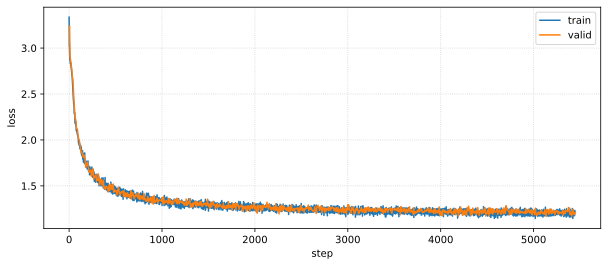

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats("svg")

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="train")
plt.plot(np.array(range(1, len(valid_losses) + 1)) * 5, valid_losses, label="valid")
plt.grid(linestyle="dotted", alpha=0.6)
plt.ylabel("loss")
plt.xlabel("step")
plt.legend();

Better performance:

In [11]:
np.array(valid_losses[-50:]).mean()

1.2144835543632508

**Remark.** Note setting `n_layers=1` we recover previous performance ~1.34 (not shown).

<br>

### Text generation

In [12]:
textgen = TextGenerator(model, vocab, device="cpu")
s = [textgen.predict("thank y", num_preds=2, temp=0.4) for i in range(20)]
(np.array(s) == "thank you").mean()

1.0

In [13]:
warmup = "mr williams i underst"
text = []
temp = []
for i in range(1, 6):
    t = 0.20 * i
    s = textgen.predict(warmup, num_preds=100, temp=t)
    text.append(s)
    temp.append(t)

In [14]:
import pandas as pd
from IPython.display import display
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame({"temp": [f"{t:.1f}" for t in temp], "text": text})
df = df.style.set_properties(**{"text-align": "left"})
display(df)

,temp,text
0,0.2,mr williams i understand the same coming and still so much and starting of the last such a little constance and the sun w
1,0.4,mr williams i understood and i was already and the absolutelity the land i had come but still my hand i was seemed to me
2,0.6,mr williams i understood about me it was a sweeping back my arms hand the self and the keering of the space and again i h
3,0.8,mr williams i understand and their buildings in account still solving up at what even perhaps that were you of a sweeter
4,1.0,mr williams i understood and what ruinest to revaiked the only exectess i could like about the but admistent on freedom o
